In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from tqdm import tqdm
import seaborn as sns
import re
import datetime
import os
import random
import h3

In [3]:
h3_l7_df = pd.read_csv('h3_l7_df_new.csv')
h3_l7_df

,id,place_of_worship,grave_yard,school,post_office,childcare,university,courthouse,fire_station,library,...,warehouse,sports_centre,detached,boathouse,barn,riding_hall,construction,ship,ruins,ohca
0,872af0424ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,872af0425ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,872af0426ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,872af0500ffffff,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,872af0501ffffff,0,0,1,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,872af6373ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
173,872af6375ffffff,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,20
174,872af6acaffffff,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
175,872af6ad9ffffff,2,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,2


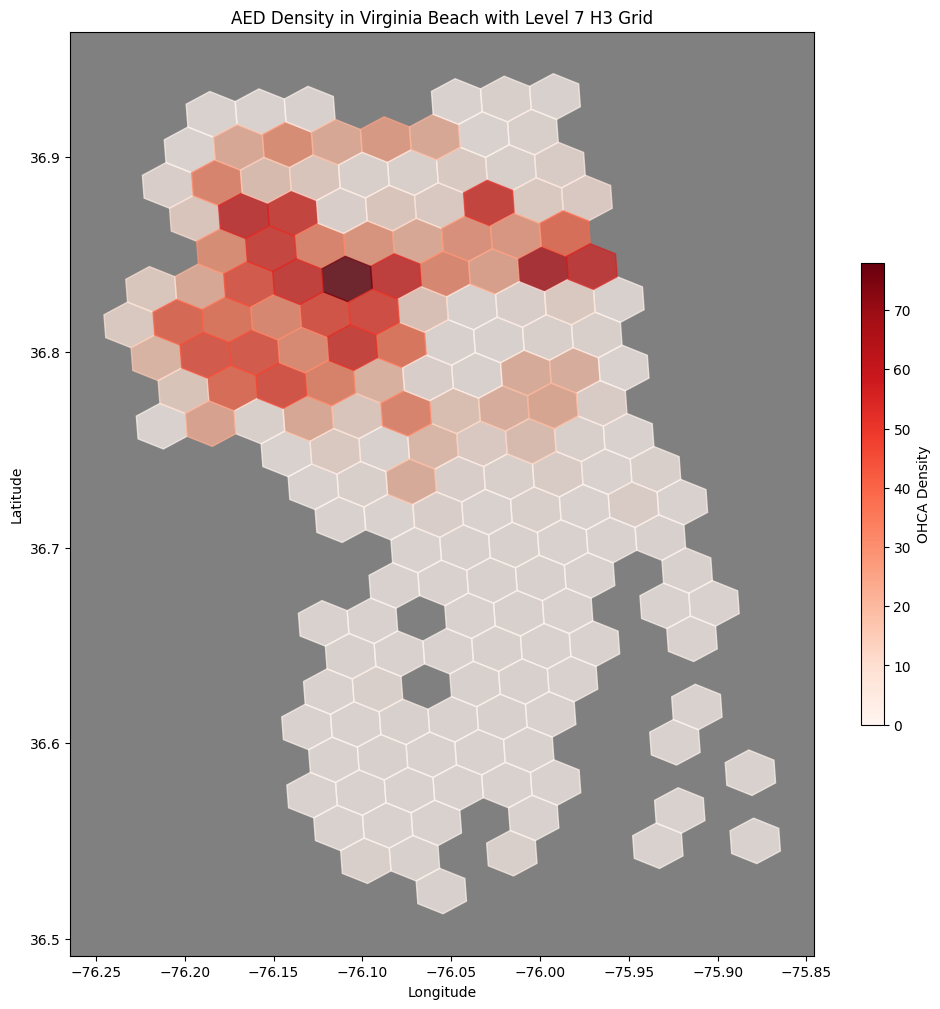

In [4]:
from shapely.geometry import Polygon
import matplotlib.colors as mcolors
import osmnx as ox

districts = ox.geocode_to_gdf([
    'Virginia Beach, Virginia, USA',
])
# Step 3: 繪製行政區背景
fig, ax = plt.subplots(figsize=(12, 12))


# Step 4: 計算各網格內的 AED 密度
density = h3_l7_df[['id', 'ohca']]

# Step 5: 繪製每個網格
for index, row in density.iterrows():
    # 將 H3 索引轉換為多邊形
    boundary = h3.h3_to_geo_boundary(row['id'], geo_json=True)
    polygon = Polygon(boundary)
    # 根據密度決定顏色
    color_norm = mcolors.Normalize(vmin=density['ohca'].min(), vmax=density['ohca'].max())
    color = plt.cm.Reds(color_norm(row['ohca']))
    ax.fill(*zip(*polygon.exterior.coords), color=color, alpha=0.7)

# Step 6: 創建並顯示顏色條
norm = mcolors.Normalize(vmin=density['ohca'].min(), vmax=density['ohca'].max())
sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, orientation='vertical', label='OHCA Density', shrink=0.5)

# Step 7: 設定地圖的細節
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('AED Density in Virginia Beach with Level 7 H3 Grid')
ax.set_facecolor('grey')

# 顯示地圖
plt.show()

In [5]:
# # 設定plt環境
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [6]:
# # 設定訓練、驗證和測試集的比例
# train_proportion = 0.7  

# train_size = int(h3_l7_df.shape[0]*train_proportion)

# seed = 9456 #666
# torch.manual_seed(seed)
# np.random.seed(seed)
# random.seed(seed)

# # h3_l7_id = np.random.choice(spatial_data.shape[0], spatial_data.shape[0])
# # spatial_data = spatial_data[h3_l7_id]
# # train_spatial_data = spatial_data[:train_size, :]
# # test_spatial_data = spatial_data[train_size:, :]

# # 隨機打亂 DataFrame
# shuffled_h3_l7_df = h3_l7_df.sample(frac=1, random_state=seed).reset_index(drop=True)

# # 分割訓練集和測試集
# train_h3_l7_df = shuffled_h3_l7_df.iloc[:train_size]
# test_h3_l7_df = shuffled_h3_l7_df.iloc[train_size:]

In [7]:
# # 將 h3_l7_df 資料框中的 'id' 列移除，僅保留數據進行正規化
# shuffled_spatial_data = shuffled_h3_l7_df.drop('id', axis=1).drop('police', axis=1)


# # # # 對數據進行正規化：將每個數據列的最小值調整為 0，最大值調整為 1
# normalized_spatial_data = (shuffled_spatial_data - shuffled_spatial_data.min()) / (shuffled_spatial_data.max() - shuffled_spatial_data.min())

# #設定OHCA正規化反函數 方便把預測結果返回原本scale
# ohca_reguli_inverse = (h3_l7_df.ohca.max()-h3_l7_df.ohca.min()) + h3_l7_df.ohca.min()

# # 將 DataFrame 轉換為 numpy array，並設定數據類型為 np.float64
# spatial_data = np.array(normalized_spatial_data).astype(np.float64)


# train_spatial_data = spatial_data[:train_size, :]
# test_spatial_data = spatial_data[train_size:, :]


In [8]:
train_index=[]
test_index=[]
for i in range(0,h3_l7_df.shape[0]):
    geo_location = h3.h3_to_geo(h3_l7_df.iloc[i]['id'])

    if (geo_location[1]) > (-76.05): #把經度大於-76.05的 當train (東邊是train)
        train_index.append(i)
    else:
        test_index.append(i)

# 分割訓練集和測試集
train_h3_l7_df = h3_l7_df.iloc[train_index]
test_h3_l7_df = h3_l7_df.iloc[test_index]

In [9]:
# 將 h3_l7_df 資料框中的 'id' 列移除，僅保留數據進行正規化
h3_spatial_data = h3_l7_df.drop('id', axis=1)


# # # 對數據進行正規化：將每個數據列的最小值調整為 0，最大值調整為 1
normalized_spatial_data = (h3_spatial_data - h3_spatial_data.min()) / (h3_spatial_data.max() - h3_spatial_data.min())

#設定OHCA正規化反函數 方便把預測結果返回原本scale
ohca_reguli_inverse = (h3_l7_df.ohca.max()-h3_l7_df.ohca.min()) + h3_l7_df.ohca.min()

# 將 DataFrame 轉換為 numpy array，並設定數據類型為 np.float64
spatial_data = np.array(normalized_spatial_data).astype(np.float64)


train_spatial_data = spatial_data[train_index]
test_spatial_data = spatial_data[test_index]

print(len(train_index))
print(len(test_index))


83
94


In [10]:
def loss_function_with_regularization(model, output, target, l1_lambda=0.01):
    # 均方誤差損失
    mse_loss = nn.MSELoss()(output, target)
    
    # 計算 L1 和 L2 正則化項
    l1_penalty = sum(torch.sum(torch.abs(param)) for param in model.parameters())
    
    # 總損失
    total_loss = mse_loss + l1_lambda * l1_penalty 
    
    return total_loss

In [11]:
class Regressor(nn.Module):
    """
    用於迴歸任務的神經網絡模型 Regressor。
    
    結構:
    - 兩層隱藏層，並使用 ReLU 激活函數
    - 最後一層為線性層，不使用激活函數（適用於迴歸）
    """
    def __init__(self, input_size=2, hidden_size=32, output_size=1):
        super().__init__()
        # 定義三層全連接層
        self.fc1 = nn.Linear(input_size, hidden_size)     # 第一層：輸入層到隱藏層
        self.fc2 = nn.Linear(hidden_size, hidden_size)    # 第二層：隱藏層到隱藏層
        self.fc3 = nn.Linear(hidden_size, output_size)    # 第三層：隱藏層到輸出層

        # 初始化權重和偏置
        nn.init.normal_(self.fc1.weight, std=0.02)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight, std=0.02)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight, std=0.02)
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, input):
        # 前向傳播過程
        output = F.relu(self.fc1(input))  # 第一層 + ReLU 激活
        output = F.relu(self.fc2(output)) # 第二層 + ReLU 激活
        output = self.fc3(output)         # 第三層（不使用激活函數）
        return output

In [12]:
window_size = 1
seed = 123 #123
torch.manual_seed(seed)
np.random.seed(seed)

def train_reg(spatial_data, 
              s_net,
              s_net_optim, 
              window_size, iter_num=5000 , l2_lambda=1e-5):
    """
    訓練 s_net  網絡來預測 spatial_data 中的數據。
    
    參數:
    - spatial_data: numpy array，包含訓練數據
    - s_net: 神經網絡模型
    - s_net_optim: 優化器
    - window_size: 每次迭代的隨機取樣大小
    - iter_num: 訓練迭代次數
    
    返回:
    - loss_array: 每次迭代的損失值
    - t_fea_array, s_fea_array: 用於存儲特徵的暫時性陣列（目前未使用）
    """

    loss_array = []     # 儲存每次迭代的損失
    t_fea_array = []    # 預留用於儲存暫時性特徵的空列表
    s_fea_array = []    # 預留用於儲存暫時性特徵的空列表

    for _ in tqdm(range(iter_num)):
        
        # 隨機選擇一組數據索引
        h3_l7_id = np.random.choice(spatial_data.shape[0] - 1, window_size)


        # 提取目標變數（即輸入的最後一列數據）並轉為 Tensor
        ohca = spatial_data[h3_l7_id, -1].reshape(-1, 1)
        ohca = torch.autograd.Variable(torch.FloatTensor(ohca))

        # p_pred 用於預測目標變數
        p_pred = s_net(torch.autograd.Variable(torch.FloatTensor(spatial_data[h3_l7_id, :-1]))).reshape(-1, 1)

        # 定義均方誤差損失
        mseloss = torch.nn.MSELoss(reduction='sum')
        loss = mseloss(p_pred, ohca)
        
        # 手動添加 L2 正則化項
        l2_reg = sum(p.pow(2.0).sum() for p in s_net.parameters())
        loss += l2_lambda * l2_reg

        # 清空前一次計算的梯度
        s_net_optim.zero_grad()
        
        
        # 計算損失的梯度
        autograd.backward(loss)

        # 更新神經網絡參數
        s_net_optim.step()
        
        # 儲存損失值
        loss_array.append(loss.detach().cpu().numpy())

    return loss_array, t_fea_array, s_fea_array

# 初始化模型和優化器
s_net = Regressor(input_size=spatial_data.shape[1] - 1, hidden_size=spatial_data.shape[1] * 2, output_size=1)
s_net_optim = optim.Adam(s_net.parameters(), lr=1e-4, weight_decay=1e-5) #lr=1e-4

iter_num=5000
# 執行訓練過程
loss_array, t_fea_array, s_fea_array = train_reg(train_spatial_data, s_net,
                                                 s_net_optim,
                                                 window_size, iter_num)

100%|██████████| 5000/5000 [00:10<00:00, 476.01it/s]


In [13]:
y_head_train = s_net(torch.autograd.Variable(torch.FloatTensor(train_spatial_data[:, :-1]))).detach().numpy()*ohca_reguli_inverse
y_train = train_spatial_data[:, -1].reshape(-1, 1)*ohca_reguli_inverse
y_head_test = s_net(torch.autograd.Variable(torch.FloatTensor(test_spatial_data[:, :-1]))).detach().numpy()*ohca_reguli_inverse
y_test = test_spatial_data[:, -1].reshape(-1, 1)*ohca_reguli_inverse


In [14]:
train_mae = np.abs(y_head_train-y_train)
train_ans_mae = train_mae.sum()/train_mae.shape[0]

print('MAE of train set= ',train_ans_mae)

# 計算殘差變異
train_ss_residual = np.sum((y_train - y_head_train) ** 2)

# 計算總變異量
train_ss_total = np.sum((y_train - np.mean(y_train)) ** 2)

# 計算 R²
train_r_squared = 1 - (train_ss_residual / train_ss_total)

print("R² of train set= ", train_r_squared)


MAE of train set=  1.2799516115562026
R² of train set=  0.9748317146134007


In [15]:
# mape_list = (y_head_test-y_test)/(test_spatial_data[:, -1].reshape(-1, 1)*h3_l7_df.ohca.max()+1)

# mape = mape_list[mape_list != np.inf].sum()/mape_list.shape[0]

test_mae = np.abs(y_head_test-y_test)
test_ans_mae = test_mae.sum()/test_mae.shape[0]

print('MAE of test set= ',test_ans_mae)

# 計算殘差變異
test_ss_residual = np.sum((y_test - y_head_test) ** 2)

# 計算總變異量
test_ss_total = np.sum((y_test - np.mean(y_test)) ** 2)

# 計算 R²
test_r_squared = 1 - (test_ss_residual / test_ss_total)

print("R² of test set= ", test_r_squared)


MAE of test set=  5.561446753588129
R² of test set=  0.7522703859183709


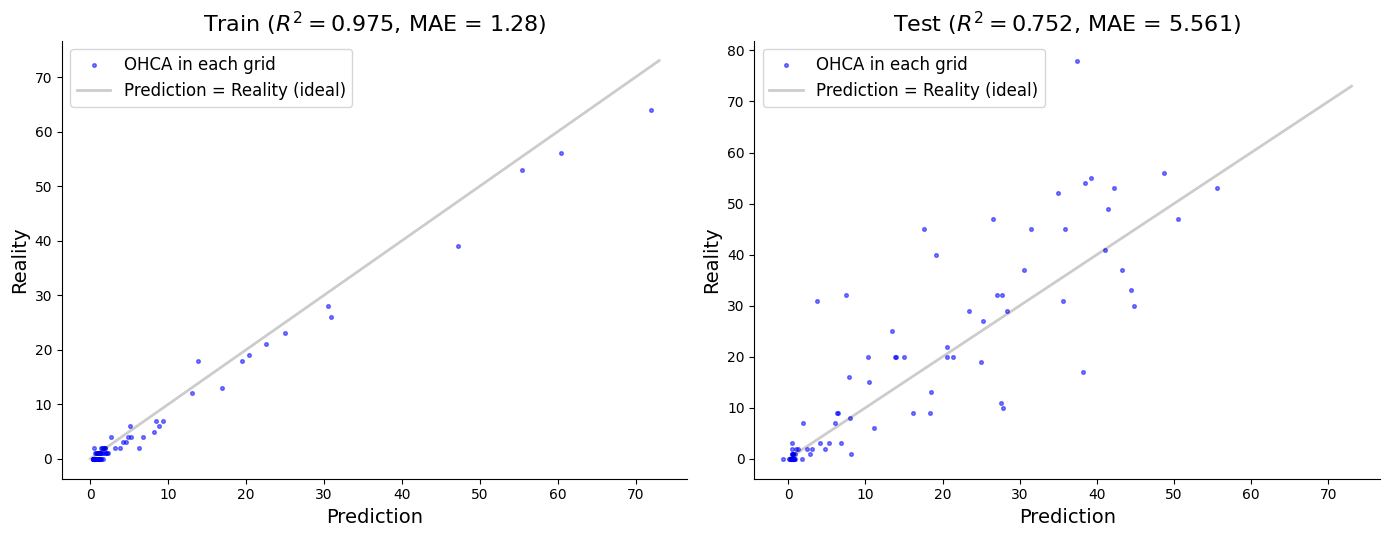

In [16]:
# 建立圖表
fig = plt.figure(figsize=(14, 10))

# 子圖 1：訓練集
ax1 = fig.add_subplot(221)
ax1.scatter(y_head_train, y_train, c="blue", alpha=0.5, label="OHCA in each grid", s=7)
ax1.plot([0, 73], [0, 73], color="black", linewidth=2, label="Prediction = Reality (ideal)", alpha=0.2)
ax1.set_title("Train ($R^2 =$" +str(round(train_r_squared,3)) + ", MAE = " + str(round(train_ans_mae,3)) + ")", fontsize=16)
ax1.set_xlabel("Prediction", fontsize=14)
ax1.set_ylabel("Reality", fontsize=14)
ax1.legend(fontsize=12)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# 子圖 2：測試集
ax2 = fig.add_subplot(222)
ax2.scatter(y_head_test, y_test, c="blue", alpha=0.5, label="OHCA in each grid", s=7)
ax2.plot([0, 73], [0, 73], color="black", linewidth=2, label="Prediction = Reality (ideal)", alpha=0.2)
ax2.set_title("Test ($R^2 =$" +str(round(test_r_squared,3)) + ", MAE = " + str(round(test_ans_mae,3)) + ")", fontsize=16)
ax2.set_xlabel("Prediction", fontsize=14)
ax2.set_ylabel("Reality", fontsize=14)
ax2.legend(fontsize=12)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

# 調整布局
plt.tight_layout()
plt.show()

C:\Users\Yuan\AppData\Local\Temp\ipykernel_25280\3528617463.py:2: RuntimeWarning: divide by zero encountered in divide
  (y_head_train- y_train)/train_spatial_data[:, -1].reshape(-1, 1)/ohca_reguli_inverse,


Text(0, 0.5, 'Number of OHCA')

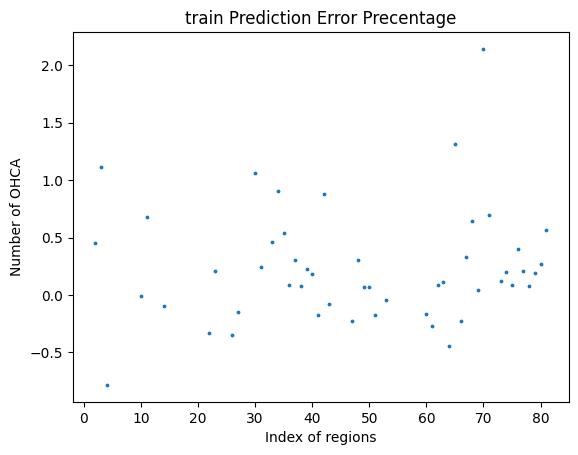

In [17]:
plt.scatter(np.arange(train_spatial_data.shape[0]),
            (y_head_train- y_train)/train_spatial_data[:, -1].reshape(-1, 1)/ohca_reguli_inverse,
            s = 3)
plt.title('train Prediction Error Precentage')
plt.xlabel('Index of regions')
plt.ylabel('Number of OHCA')

Text(0, 0.5, 'Reality')

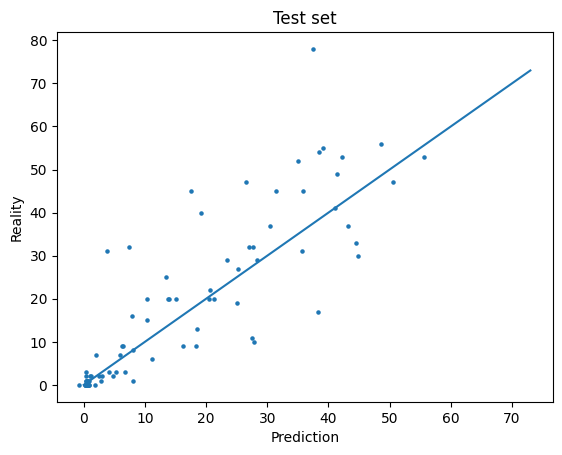

In [18]:
plt.scatter(y_head_test,
            y_test,
            s = 5)
plt.plot([0, 73], [0, 73])
plt.title('Test set')
plt.xlabel('Prediction')
plt.ylabel('Reality')

Text(0, 0.5, 'Number of OHCA')

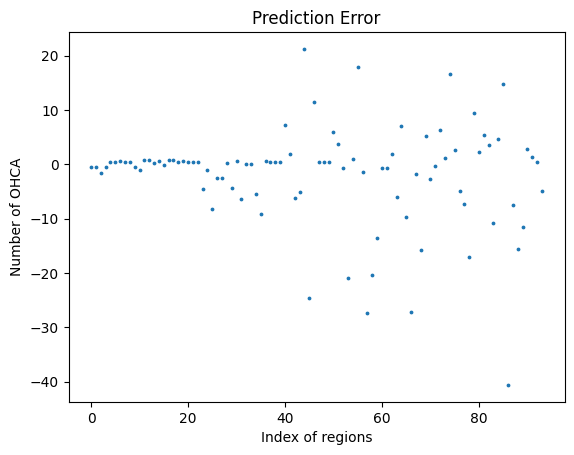

In [19]:
plt.scatter(np.arange(test_spatial_data.shape[0]),
            y_head_test- y_test,
            s = 3)
plt.title('Prediction Error')
plt.xlabel('Index of regions')
plt.ylabel('Number of OHCA')

C:\Users\Yuan\AppData\Local\Temp\ipykernel_25280\2933142730.py:2: RuntimeWarning: divide by zero encountered in divide
  (y_head_test- y_test)/test_spatial_data[:, -1].reshape(-1, 1)/ohca_reguli_inverse,


Text(0, 0.5, 'Number of OHCA')

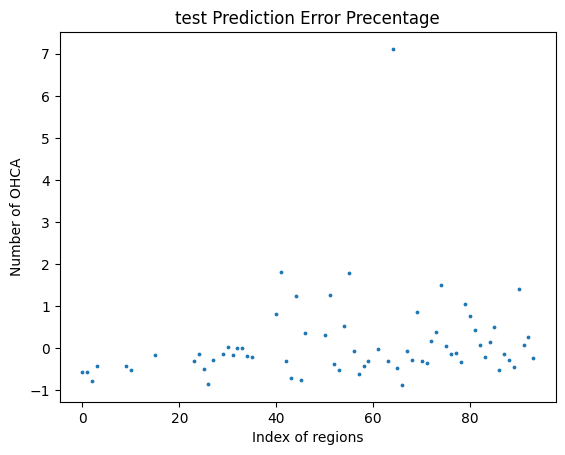

In [20]:
plt.scatter(np.arange(test_spatial_data.shape[0]),
            (y_head_test- y_test)/test_spatial_data[:, -1].reshape(-1, 1)/ohca_reguli_inverse,
            s = 3)
plt.title('test Prediction Error Precentage')
plt.xlabel('Index of regions')
plt.ylabel('Number of OHCA')


In [21]:
# mape_list = (y_head_test-y_test)/(test_spatial_data[:, -1].reshape(-1, 1)*h3_l7_df.ohca.max()+1)

# mape = mape_list[mape_list != np.inf].sum()/mape_list.shape[0]

mae = np.abs(y_head_test-y_test)
ans_mae = mae.sum()/mae.shape[0]

print('MAE of test set= ',ans_mae)

# 計算殘差變異
ss_residual = np.sum((y_test - y_head_test) ** 2)

# 計算總變異量
ss_total = np.sum((y_test - np.mean(y_test)) ** 2)

# 計算 R²
r_squared = 1 - (ss_residual / ss_total)

n = mae.shape[0]          # Number of data points
p = train_spatial_data.shape[1]            # Number of predictors
print("R² of test set= ", r_squared)

# # Adjusted R-squared calculation
# r_squared_adj = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)
# print("ADJ R² of test set= ", r_squared_adj)

MAE of test set=  5.561446753588129
R² of test set=  0.7522703859183709


In [22]:
# 将 y_head_test 添加为新的列
test_h3_l7_df.loc[:, "y_head_test"] = y_head_test

# 检查结果
test_h3_l7_df

C:\Users\Yuan\AppData\Local\Temp\ipykernel_25280\65216883.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_h3_l7_df.loc[:, "y_head_test"] = y_head_test


,id,place_of_worship,grave_yard,school,post_office,childcare,university,courthouse,fire_station,library,...,sports_centre,detached,boathouse,barn,riding_hall,construction,ship,ruins,ohca,y_head_test
0,872af0424ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.429751
1,872af0425ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.427820
2,872af0426ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0.427820
5,872af0502ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.578968
6,872af0503ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.420755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,872af6370ffffff,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,25,13.477487
170,872af6371ffffff,2,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,4.790933
171,872af6372ffffff,3,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,20,21.312162
172,872af6373ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,2.499578


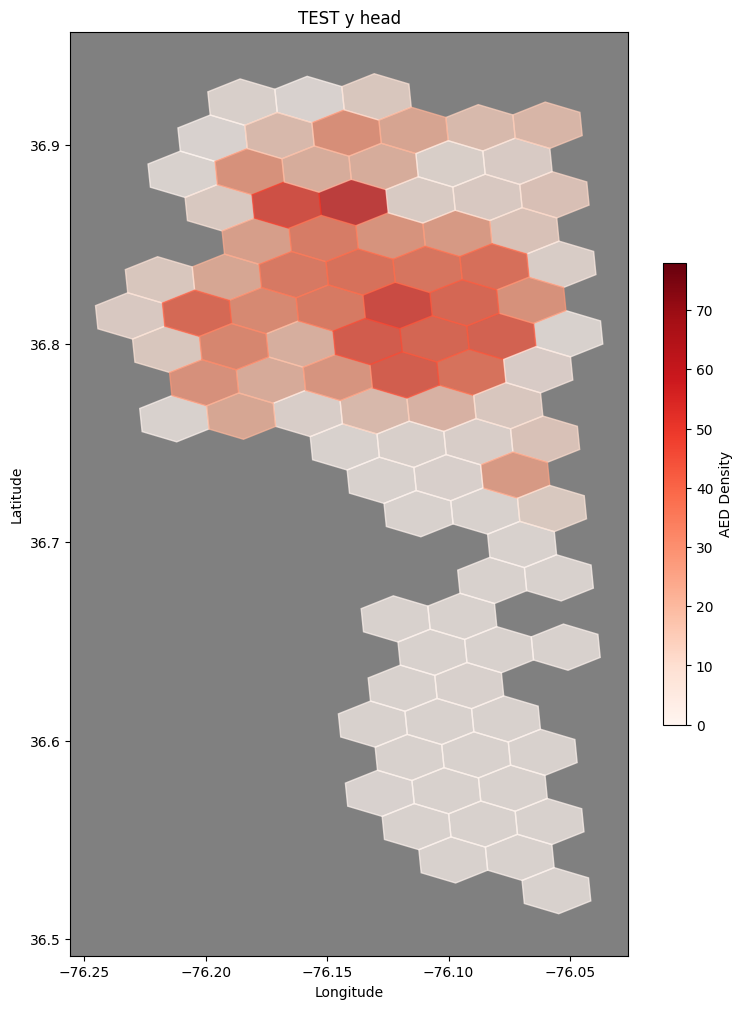

In [23]:
# Step 3: 繪製行政區背景
fig, ax = plt.subplots(figsize=(9, 12))

# Step 4: 計算各網格內的 AED 密度
density_test = test_h3_l7_df[['id', 'y_head_test']]

# Step 5: 繪製每個網格
for index, row in density_test.iterrows():
    # 將 H3 索引轉換為多邊形
    boundary = h3.h3_to_geo_boundary(row['id'], geo_json=True)
    polygon = Polygon(boundary)
    # 根據密度決定顏色
    color_norm = mcolors.Normalize(vmin=density['ohca'].min(), vmax=density['ohca'].max())
    color = plt.cm.Reds(color_norm(row['y_head_test']))
    ax.fill(*zip(*polygon.exterior.coords), color=color, alpha=0.7)

# Step 6: 創建並顯示顏色條
norm = mcolors.Normalize(vmin=density['ohca'].min(), vmax=density['ohca'].max())
sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, orientation='vertical', label='AED Density', shrink=0.5)

# Step 7: 設定地圖的細節
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('TEST y head')
ax.set_facecolor('grey')

# 顯示地圖
plt.show()


# fig.savefig('AED_Shenzhen.png')

# train set perfromance

In [24]:
# 将 y_head_train 添加为新的列
train_h3_l7_df.loc[:, "y_head_train"] = y_head_train

# 检查结果
train_h3_l7_df

C:\Users\Yuan\AppData\Local\Temp\ipykernel_25280\660158301.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_h3_l7_df.loc[:, "y_head_train"] = y_head_train


,id,place_of_worship,grave_yard,school,post_office,childcare,university,courthouse,fire_station,library,...,sports_centre,detached,boathouse,barn,riding_hall,construction,ship,ruins,ohca,y_head_train
3,872af0500ffffff,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.914982
4,872af0501ffffff,0,0,1,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,1.100651
7,872af0504ffffff,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,1.450480
8,872af0505ffffff,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2.118020
9,872af0509ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0.433502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,872af636dffffff,4,0,3,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,56,60.370319
168,872af636effffff,2,0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,26,30.906292
174,872af6acaffffff,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1.267292
175,872af6ad9ffffff,2,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,2,3.129514


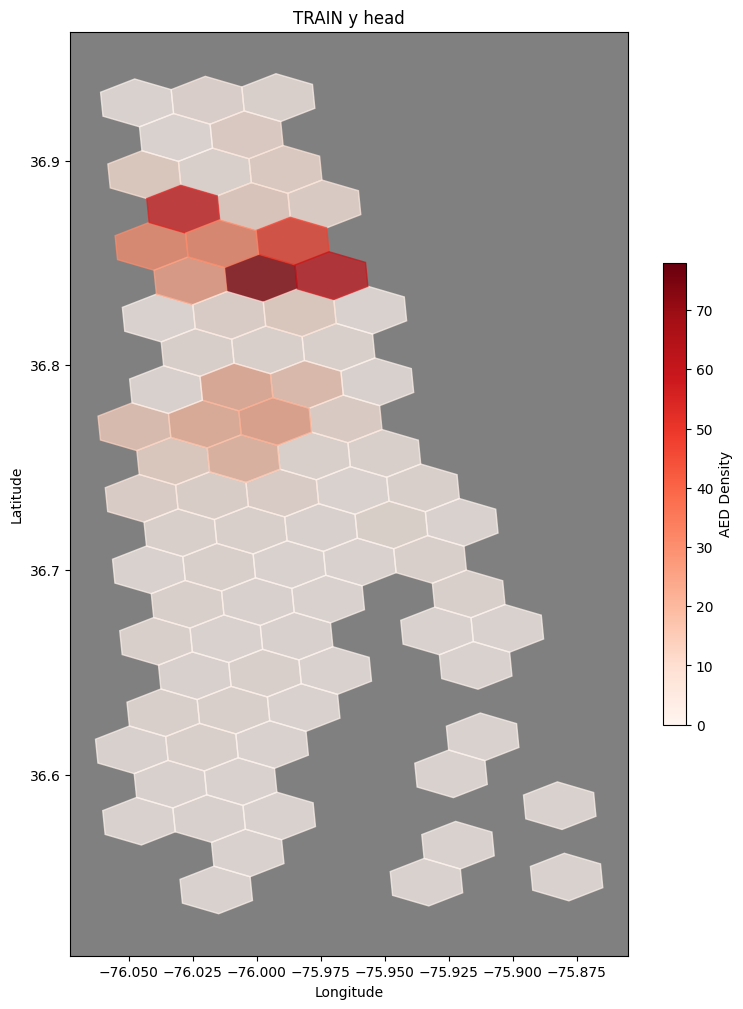

In [25]:
# Step 3: 繪製行政區背景
fig, ax = plt.subplots(figsize=(9, 12))

# Step 4: 計算各網格內的 AED 密度
density_train = train_h3_l7_df[['id', 'y_head_train']]

# Step 5: 繪製每個網格
for index, row in density_train.iterrows():
    # 將 H3 索引轉換為多邊形
    boundary = h3.h3_to_geo_boundary(row['id'], geo_json=True)
    polygon = Polygon(boundary)
    # 根據密度決定顏色
    color_norm = mcolors.Normalize(vmin=density['ohca'].min(), vmax=density['ohca'].max())
    color = plt.cm.Reds(color_norm(row['y_head_train']))
    ax.fill(*zip(*polygon.exterior.coords), color=color, alpha=0.7)

# Step 6: 創建並顯示顏色條
norm = mcolors.Normalize(vmin=density['ohca'].min(), vmax=density['ohca'].max())
sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, orientation='vertical', label='AED Density', shrink=0.5)

# Step 7: 設定地圖的細節
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('TRAIN y head')
ax.set_facecolor('grey')

# 顯示地圖
plt.show()
